Loading Dataset...
Extracting Features (This may take a moment)...

--- Training & Evaluation ---
Training Random_Forest...
   Saved to models/random_forest.pkl
   Accuracy: 99.11%
Training SVM...
   Saved to models/svm.pkl
   Accuracy: 97.20%
Training Logistic_Regression...
   Saved to models/logistic_regression.pkl
   Accuracy: 97.29%

Generating Visualizations for Best Model (Random Forest)...

All tasks completed successfully.


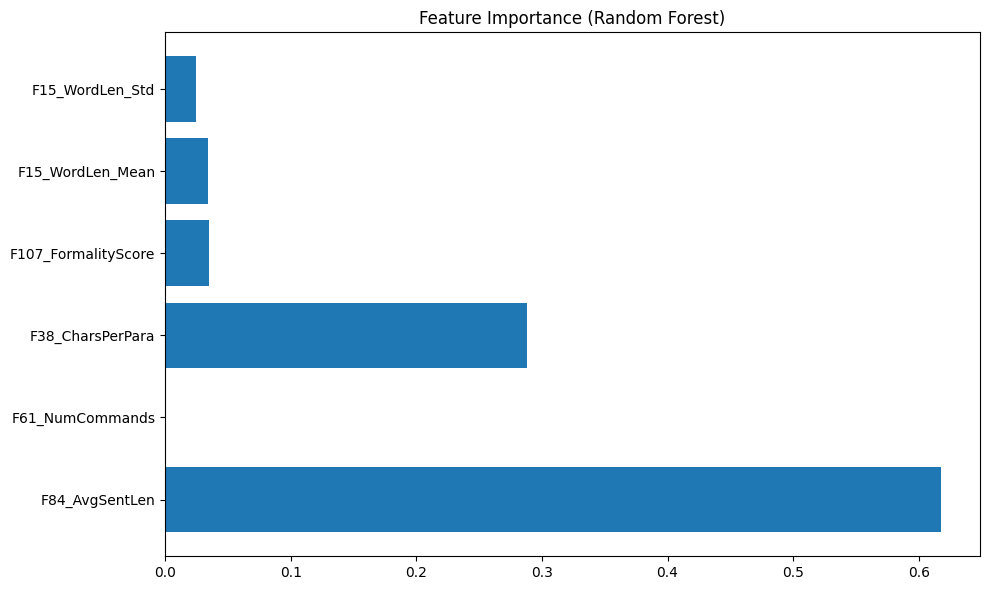

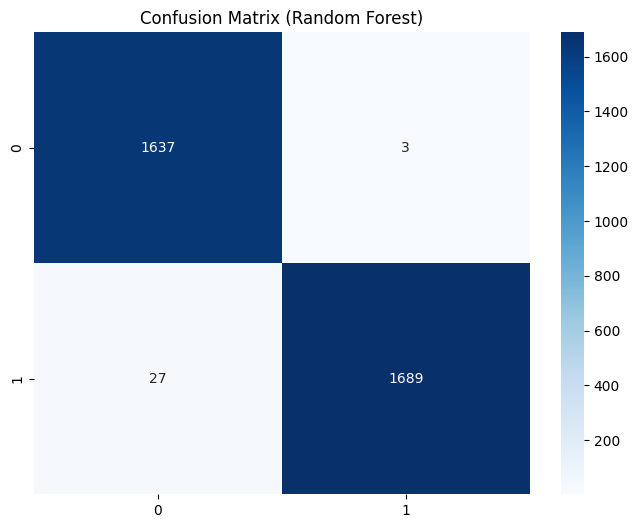

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from nltk.tokenize import word_tokenize, sent_tokenize
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression  # تمت الإضافة
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ensure Arabic tokenizers are available [cite: 95-99]
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# --- 1. Data Acquisition [cite: 100-116] ---
def load_full_data():
    print("Loading Dataset...")
    dataset = load_dataset("KFUPM-JRCAI/arabic-generated-abstracts")
    dfs = []
    
    for split in ['by_polishing', 'from_title', 'from_title_and_content']:
        if split in dataset:
            dfs.append(pd.DataFrame(dataset[split]))
            
    df_merged = pd.concat(dfs, ignore_index=True)
    
    # Balancing Logic
    human = df_merged['original_abstract'].dropna().tolist()
    ai = []
    for col in df_merged.columns:
        if 'generated_abstract' in col:
            ai.extend(df_merged[col].dropna().tolist())
            
    min_len = min(len(human), len(ai))
    
    return pd.DataFrame({
        'text': human[:min_len] + ai[:min_len],
        'label': [0] * min_len + [1] * min_len
    }).sample(frac=1, random_state=42).reset_index(drop=True)

# --- 2. Feature Engineering [cite: 117-160] ---
def feat_word_len_dist(text):
    if not isinstance(text, str) or not text.strip(): return 0, 0
    words = word_tokenize(text)
    if not words: return 0, 0
    lengths = [len(w) for w in words]
    return np.mean(lengths), np.std(lengths)

def feat_chars_per_paragraph(text):
    if not isinstance(text, str): return 0
    paragraphs = [p for p in text.split('\n') if p.strip()]
    if not paragraphs: return 0
    return np.mean([len(p) for p in paragraphs])

def feat_num_commands(text):
    if not isinstance(text, str): return 0
    words = word_tokenize(text)
    command_keywords = {"انظر", "لاحظ", "تأمل", "قارن", "احسب", "استنتج", "اكتب", "اقرأ", "حلل", "ناقش", "اشرح", "طبق"}
    count = 0
    for w in words:
        clean_w = re.sub(r'[^\w]', '', w)
        if clean_w in command_keywords:
            count += 1
    return count

def feat_avg_sentence_len(text):
    if not isinstance(text, str): return 0
    sentences = sent_tokenize(text)
    if not sentences: return 0
    word_counts = [len(word_tokenize(s)) for s in sentences]
    return np.mean(word_counts)

def feat_formality_score(text):
    if not isinstance(text, str): return 0
    words = word_tokenize(text)
    if not words: return 0
    formal = 0
    informal = 0
    pronouns = {"أنا", "نحن", "أنت", "هو", "هي"}
    for w in words:
        if w.startswith("ال") or w.endswith("ية") or len(w) > 6:
            formal += 1
        elif w in pronouns or len(w) < 2:
            informal += 1
    return (formal - informal) / len(words)

# --- 3. Main Execution ---
if __name__ == "__main__":
    
    # A. Load & Prepare Data
    df_raw = load_full_data()
    if not os.path.exists('data/raw'): os.makedirs('data/raw')
    df_raw.to_excel("data/raw/raw_data.xlsx", index=False)
    
    print("Extracting Features (This may take a moment)...")
    processed_df = df_raw.copy()
    processed_df['F84_AvgSentLen'] = df_raw['text'].apply(feat_avg_sentence_len)
    processed_df['F61_NumCommands'] = df_raw['text'].apply(feat_num_commands)
    processed_df['F38_CharsPerPara'] = df_raw['text'].apply(feat_chars_per_paragraph)
    processed_df['F107_FormalityScore'] = df_raw['text'].apply(feat_formality_score)
    f15 = df_raw['text'].apply(feat_word_len_dist)
    processed_df['F15_WordLen_Mean'] = [x[0] for x in f15]
    processed_df['F15_WordLen_Std'] = [x[1] for x in f15]
    
    if not os.path.exists('data/processed'): os.makedirs('data/processed')
    processed_df.to_excel("data/processed/processed_data.xlsx", index=False)
    
    # B. Split Data
    X = processed_df.drop(['text', 'label'], axis=1)
    y = processed_df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # C. Initialize Models [cite: 75-78]
    models = {
        "Random_Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='linear', random_state=42), # Linear as per Table 1
        "Logistic_Regression": LogisticRegression(max_iter=1000, random_state=42)
    }

    if not os.path.exists('models'): os.makedirs('models')
    if not os.path.exists('reports/figures'): os.makedirs('reports/figures')

    # D. Train, Evaluate, and Save All Models
    print("\n--- Training & Evaluation ---")
    
    # للحفظ عشان الرسم البياني لاحقاً
    rf_model = None 

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        
        # Save Model [cite: 237]
        model_path = f'models/{name.lower()}.pkl'
        joblib.dump(model, model_path)
        print(f"   Saved to {model_path}")
        
        # Evaluate
        pred = model.predict(X_test)
        acc = accuracy_score(y_test, pred)
        print(f"   Accuracy: {acc*100:.2f}%")
        
        if name == "Random_Forest":
            rf_model = model

    # E. Visualization (Focus on Random Forest as Best Performer) [cite: 180-184]
    print("\nGenerating Visualizations for Best Model (Random Forest)...")
    
    # Feature Importance
    plt.figure(figsize=(10,6))
    plt.barh(X.columns, rf_model.feature_importances_)
    plt.title("Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.savefig('reports/figures/feature_importance.png')
    
    # Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix(y_test, rf_model.predict(X_test)), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (Random Forest)")
    plt.savefig('reports/figures/confusion_matrix.png')
    
    print("\nAll tasks completed successfully.")